Here is an example of extracting profile information from the NPZ files and plotting the average.

First we start with the imports. 

In [13]:
import sys
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import *
# sys.path.append('/home/jovyan')
import h5py

Now we set the simulation information, including the cosmological parameters and snapshot. 

If we want to further select by halo mass, the values are set by mh_low and mh_high. For this example we will just take the entire range, which was set to be $10^{10}-10^{15} M_\odot/h$ in istk_params_tng.py previously.

In [28]:
sim='1P_p1'
snap='024'
z=0.0
h=0.6711
omegab=0.049

omegam,sigma8=np.loadtxt(f"/home/jovyan/Data/Sims/IllustrisTNG/{sim.split('_')[0]}/CosmoAstroSeed_IllustrisTNG_L25n256_CV.txt",usecols=(1,2),unpack=True)
omegalam=1.0-omegam

mh_low=10**10.
mh_high=10**15.
mh_cut=False

FileNotFoundError: /home/jovyan/Data/Sims/IllustrisTNG/1P/CosmoAstroSeed_IllustrisTNG_L25n256_CV.txt not found.

Here are some functions that will help us select and radially cut the profiles:

1. mhalo_cut removes the profiles of halos outside the desired range, defined by mh_low and mh_high if mh_cut is set to be True.
2. outer_cut removes bins beyond a set radius.
3. inner_cut removes bins inside a set radius.
4. get_errors takes the percentiles in each bin to show the distribution


In [4]:
def mhalo_cut(mh_low,mh_high,mstar,mh,rh,val_dens,bins):
    idx=np.where((mh > mh_low) & (mh < mh_high))
    mstar,mh,rh=mstar[idx],mh[idx],rh[idx]
    nprofs=len(mh)
    val_dens=val_dens[idx,:]
    val_dens=np.reshape(val_dens,(nprofs,bins))
    return mstar,mh,rh,val_dens,nprofs

def outer_cut(outer_cut,x,arr):
    idx=np.where(x <= outer_cut)
    idx=np.array(idx[0])
    x,arr=x[idx],arr[:,idx]
    return x,arr

def inner_cut(inner_cut,x,arr):
    idx=np.where(x >= inner_cut)
    idx=np.array(idx[0])
    x,arr=x[idx],arr[:,idx]
    return x,arr

def get_errors(arr):
    arr=np.array(arr)
    percent_84=np.apply_along_axis(lambda v: np.percentile(v[np.nonzero(v)],84),0,arr)
    percent_50=np.apply_along_axis(lambda v: np.percentile(v[np.nonzero(v)],50),0,arr)
    percent_16=np.apply_along_axis(lambda v: np.percentile(v[np.nonzero(v)],16),0,arr)
    errup=percent_84-percent_50
    errlow=percent_50-percent_16

    std_arr=[]
    for i in range(arr.shape[1]): #for every radial bin
        std_arr.append(np.std(np.apply_along_axis(lambda v: np.log10(v[np.nonzero(v)]),0,arr[:,i])))
    std=np.array(std_arr)
    return errup,errlow,std

In [36]:
stacks_dens.keys()

<KeysViewHDF5 ['Profiles', 'Group_M_Crit200', 'Group_R_Crit200', 'nprofs', 'nbins', 'GroupFirstSub', 'GroupSFR', 'GroupMassType_Stellar', 'GroupBHMass', 'GroupBHMdot', 'GroupCMx', 'GroupCMy', 'GroupCMz', 'Group_GasH', 'Group_GasHe', 'Group_GasC', 'Group_GasN', 'Group_GasO', 'Group_GasNe', 'Group_GasMg', 'Group_GasSi', 'Group_GasFe', 'GroupGasMetallicity', 'GroupLen', 'GroupMass', 'GroupNsubs', 'Group_StarH', 'Group_StarHe', 'Group_StarC', 'Group_StarN', 'Group_StarO', 'Group_StarNe', 'Group_StarMg', 'Group_StarSi', 'Group_StarFe', 'GroupStarMetallicity', 'GroupVelx', 'GroupVely', 'GroupVelz', 'GroupWindMass', 'Group_M_Crit500', 'Group_M_Mean200', 'Group_M_TopHat200', 'Group_R_Crit500', 'Group_R_Mean200', 'Group_R_TopHat200', 'ID']>

Now we can load in the profiles and take a few quantities stored from the group catalog.

In [35]:
stacks_dens=h5py.File('/home/jovyan/home/illstack_CAMELS/CAMELS_example/Batch_hdf5_files/test/IllustrisTNG_'+sim+'_'+snap+'.hdf5')

val_dens       = stacks_dens['Profiles']['gasdens']
bins           = stacks_dens['nbins']
r              = stacks_dens['Profiles']['r'] #ckpc/h
nprofs         = stacks_dens['nprofs']
mh             = stacks_dens['M_Crit200'] #units 1e10 Msol/h, M200c
rh             = stacks_dens['R_Crit200'] #R200c
mstar          = stacks_dens['mstar'] #1e10 Msol/h

KeyError: "Unable to synchronously open object (object 'M_Crit200' doesn't exist)"

We need to account for redshift and h if we want to plot physical quantities (vs. comoving) without h.

In [14]:
#Adjust for comoving units and h
comoving_factor=1.0+z
mh       *= 1e10
mstar    *= 1e10
mh       /= h
mstar    /= h
rh       /= h
rh      /= comoving_factor
val_dens *= 1e10 * h**2
val_dens *= comoving_factor**3

#For unscaled profiles
r /= h
r /= comoving_factor

Run the next cell if we want to further cut by halo mass.

In [ ]:
#Cut by halo mass
mstar,mh,rh,val_dens,nprofs=mhalo_cut(mh_low,mh_high,mstar,mh,rh,val_dens,bins)  
    
    

Sometimes the profiles don't have any information in a few bins, so we can cut by radius.

In [15]:
#Sometimes the profiles have zeros in inner/outer bins, so we can cut them out

r_mpc=r/1.e3
    
r_mpc_cut,val_dens=outer_cut(5,r_mpc,val_dens)
r_mpc_cut2,val_dens=inner_cut(1.e-2,r_mpc_cut,val_dens)

Lastly, we take the mean in each radial bin (ignoring any zeros) and plot.

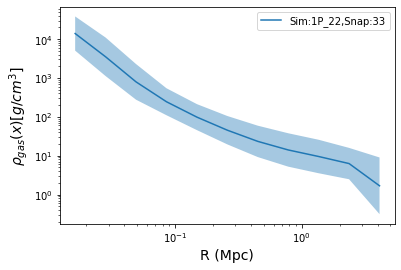

In [17]:
#Take mean and get distribution, ignore any zeros

mean_dens=np.apply_along_axis(lambda v: np.median(v[np.nonzero(v)]),0,val_dens)
errup_dens,errlow_dens,std_dens=get_errors(val_dens)

plt.loglog(r_mpc_cut2,mean_dens,label='Sim:%s,Snap:%s'%(sim,snap))
plt.fill_between(r_mpc_cut2,10**(np.log10(mean_dens)+std_dens),10**(np.log10(mean_dens)-std_dens),alpha=0.4)
plt.ylabel(r"$\rho_{gas}(x) [g/cm^3]$ ",size=14)
plt.xlabel(r'R (Mpc)',size=14)
plt.legend()

plt.show()

